# Model recovery analysis

Last access (y.m.d): 19.13.06  
Last update (y.m.d): 19.13.06

In this notebook, I'll look at the model recovery analysis which was started in the lead-up to VSS 2019 (i.e. April/May 2019). In this analysis, I choose a set of parameters for the V1 model, simulate a full experiment from the model using those parameters, and then run the optimization on the simulated data. The goal is to ask if the chosen parameters can be recovered. Failures are informative - they suggest any of the following:
- ill-specified parameterization with, for example, degeneracies. These can result in, for example, no response change from the adjustement of a given parameter, or multiple parameters that can trade-off in a way that gives the same model response
- failure of the optimization routine

### Initialization

In [10]:
import numpy as np
import os
import helper_fcns as hf
from scipy.stats.mstats import gmean
import autoreload
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
import matplotlib.backends.backend_pdf as pltSave
%matplotlib inline

expDir = 'V1_orig/'
expName = 'dataList_mr.npy';
fitBase = 'mr_fitList_190502cA';
lossType = 4; 
savePlt = 1;
# descrName = 'descrFits_190503_poiss_flex.npy';
# descrModName = 'descrFitsModel.npy';
# respName = 'respAboveBase.npy';

base_dir = os.getcwd() + '/';
data_loc = base_dir + expDir + 'structures/';
save_loc = base_dir + expDir + 'figures/';

In [23]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['font.style'] = 'oblique'
rcParams['font.size'] = 20;
rcParams['pdf.fonttype'] = 3 # should be 42, but there are kerning issues
rcParams['ps.fonttype'] = 3 # should be 42, but there are kerning issues
rcParams['lines.markersize'] = 8;

import warnings
warnings.filterwarnings('once')

In [3]:
dataList = hf.np_smart_load(data_loc + expName);
flatFit = hf.np_smart_load(data_loc + hf.fitList_name(fitBase, 1, lossType));
wghtFit = hf.np_smart_load(data_loc + hf.fitList_name(fitBase, 2, lossType));

# hf.get_exp_ind(data_loc, dataList['unitName'][-1])
# hf.get_exp_params()
# nCells = 59;
# nFamilies = 5;
# nCons = 2;

# useLowRespCut = 1; # should you filter the data based on analysis in "Considering responsivity..."

# height = 3/4; # measure BW at half-height
# sf_range = [0.01, 10]; # allowed values of 'mu' for fits - see descr_fit.py for details

### Organize (and plot) the model recovery results

In [4]:
gt_flat = [];
gt_wght = [];
fit_flat = [];
fit_wght = [];

for c in range(len(dataList['unitName'])):
    curr = hf.np_smart_load(data_loc + dataList['unitName'][c] + '_sfm.npy');

    gt_flat.append(hf.get_recovInfo(curr, 1)[0]); # 1 - flat
    fit_flat.append(flatFit[c]['params']);

    gt_wght.append(hf.get_recovInfo(curr, 2)[0]); # 2 - wght
    fit_wght.append(wghtFit[c]['params']);

### organize
comps = [[gt_flat, fit_flat], [gt_wght, fit_wght]]
case_str = ['flat', 'wght'];
gt_str = ['gt', 'fit']
color = ['k', 'r']

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


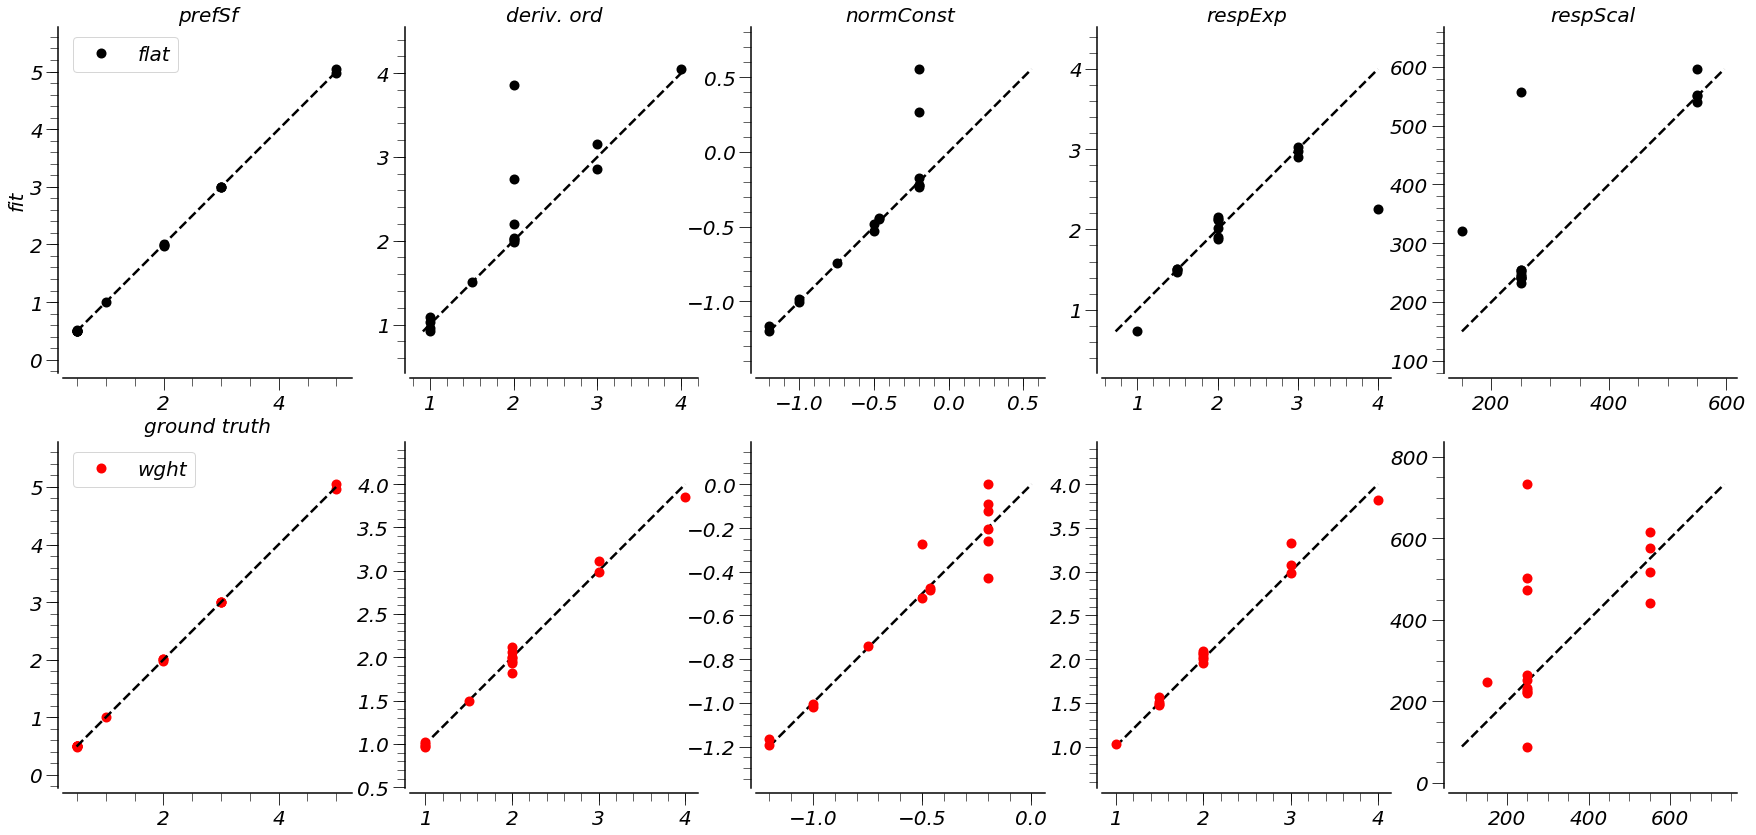

In [24]:
comp_max = lambda a, b: np.maximum(np.max(a), np.max(b))
comp_min = lambda a, b: np.minimum(np.min(a), np.min(b))

nCases = len(comps);
nParams = 5;
f, ax = plt.subplots(nCases, nParams, figsize=(6*nParams, 7*nCases))
paramLabels = ['prefSf', 'deriv. ord', 'normConst', 'respExp', 'respScal']


for i in range(nCases):
    curr_case = comps[i]; # i.e. flat or weighted
    
    for j in range(len(paramLabels)):
        if j == 0 and i == 0:
            ax[i, j].set_xlabel('ground truth')
            ax[i, j].set_ylabel('fit')
        if i == 0:
            ax[i, j].set_title('%s' % paramLabels[j])
    
    # prefSf
    gt_prefSf = [x[0] for x in comps[i][0]]
    fit_prefSf = [x[0] for x in comps[i][1]]
    low = comp_min(gt_prefSf, fit_prefSf)
    hi = comp_max(gt_prefSf, fit_prefSf)
    ax[i, 0].plot(gt_prefSf, fit_prefSf, '%so' % color[i], label=case_str[i])
    ax[i, 0].plot([low, hi], [low, hi], 'k--')
    ax[i, 0].axis('equal')
    ax[i, 0].legend()
    
    # deriv ord
    gt_DO = [x[1] for x in comps[i][0]]
    fit_DO = [x[1] for x in comps[i][1]]
    low = comp_min(gt_DO, fit_DO)
    hi = comp_max(gt_DO, fit_DO)
    ax[i, 1].plot([low, hi], [low, hi], 'k--')
    ax[i, 1].plot(gt_DO, fit_DO, '%so' % color[i])
    ax[i, 1].axis('equal')
    
    # normConst
    gt_const = [x[2] for x in comps[i][0]]
    fit_const = [x[2] for x in comps[i][1]]
    low = comp_min(gt_const, fit_const)
    hi = comp_max(gt_const, fit_const)
    ax[i, 2].plot([low, hi], [low, hi], 'k--')
    ax[i, 2].plot(gt_const, fit_const, '%so' % color[i])
    ax[i, 2].axis('equal')
    
    # respExp
    gt_rExp = [x[3] for x in comps[i][0]]
    fit_rExp = [x[3] for x in comps[i][1]]
    low = comp_min(gt_rExp, fit_rExp)
    hi = comp_max(gt_rExp, fit_rExp)
    ax[i, 3].plot([low, hi], [low, hi], 'k--')
    ax[i, 3].plot(gt_rExp, fit_rExp, '%so' % color[i])
    ax[i, 3].axis('equal')
    
    # respScalar
    gt_rScal = [x[4] for x in comps[i][0]]
    fit_rScal = [x[4] for x in comps[i][1]]
    low = comp_min(gt_rScal, fit_rScal)
    hi = comp_max(gt_rScal, fit_rScal)
    ax[i, 4].plot([low, hi], [low, hi], 'k--')
    ax[i, 4].plot(gt_rScal, fit_rScal, '%so' % color[i])
    ax[i, 4].axis('equal')

sns.despine(offset=5)

if savePlt:
    saveName = "/%s_%s.pdf" % (fitBase, expDir.replace('/', ''))
    full_save = os.path.dirname(save_loc);
    if not os.path.exists(full_save):
        os.makedirs(full_save)
    pdfSv = pltSave.PdfPages(full_save + saveName);
    pdfSv.savefig(f) # only one figure here...
    pdfSv.close()

Comments on the recovery:

- preferred spatial frequency and response exponent are well recovered
- derivative order is poorly constrained with the flat normalization model 
- for both model forms, the normalization constant is degenerate at high values, which is not particularly surprising: once the normalization constant is high enough that the tuning of the normalization (or more generally, the normalization pool response) is irrelevant, any change in the constant results in minimal changes, only
- response scalar is poorly recovered

### Now for tuned normalization only

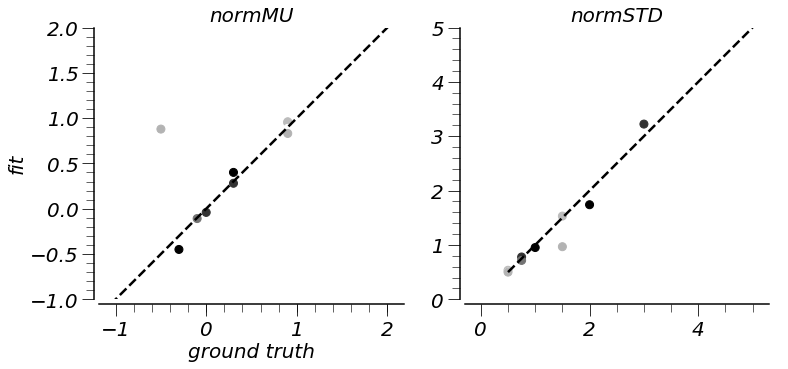

In [25]:
comp_max = lambda a, b: np.maximum(np.max(a), np.max(b))
comp_min = lambda a, b: np.minimum(np.min(a), np.min(b))

paramLabels = ['normMU', 'normSTD'];
nParams = len(paramLabels);
f, ax = plt.subplots(1, nParams, figsize=(6*nParams, 5*1))

gtConstNorm = (gt_const - np.min(gt_const))/(np.max(gt_const)-np.min(gt_const))
# gtDoNorm = (gt_DO - np.min(gt_DO))/(np.max(gt_DO)-np.min(gt_DO))
clrMap = cm.gray(gtConstNorm);

for j in range(len(paramLabels)):
    if j == 0:
        ax[j].set_xlabel('ground truth')
        ax[j].set_ylabel('fit')
    ax[j].set_title('%s' % paramLabels[j])
    
# normMU
gt_mu = [x[8] for x in gt_wght]
fit_mu = [x[8] for x in fit_wght]
low = comp_min(gt_mu, fit_mu)
hi = comp_max(gt_mu, fit_mu)
ax[0].scatter(gt_mu, fit_mu, c=clrMap);
ax[0].plot([low, hi], [low, hi], 'k--');
ax[0].axis('equal');
ax[0].set_xlim([-1, 2]);
ax[0].set_ylim([-1, 2]);

# normSTD
gt_std = [x[9] for x in gt_wght]
fit_std = [x[9] for x in fit_wght]
low = comp_min(gt_std, fit_std)
hi = comp_max(gt_std, fit_std)
ax[1].plot([low, hi], [low, hi], 'k--');
ax[1].scatter(gt_std, fit_std, c=clrMap);
ax[1].axis('equal');
ax[1].set_xlim([0, 5]);
ax[1].set_ylim([0, 5]);

sns.despine(offset=5)

if savePlt:
    saveName = "/%s_%s_norm.pdf" % (fitBase, expDir.replace('/', ''))
    full_save = os.path.dirname(save_loc);
    if not os.path.exists(full_save):
        os.makedirs(full_save)
    pdfSv = pltSave.PdfPages(full_save + saveName);
    pdfSv.savefig(f) # only one figure here...
    pdfSv.close()

Comments:

- recovered well in several cases, but some failures

### Confounded parameters?

Here, let's plot some of the parameters against each other to see if they are playing off of one another

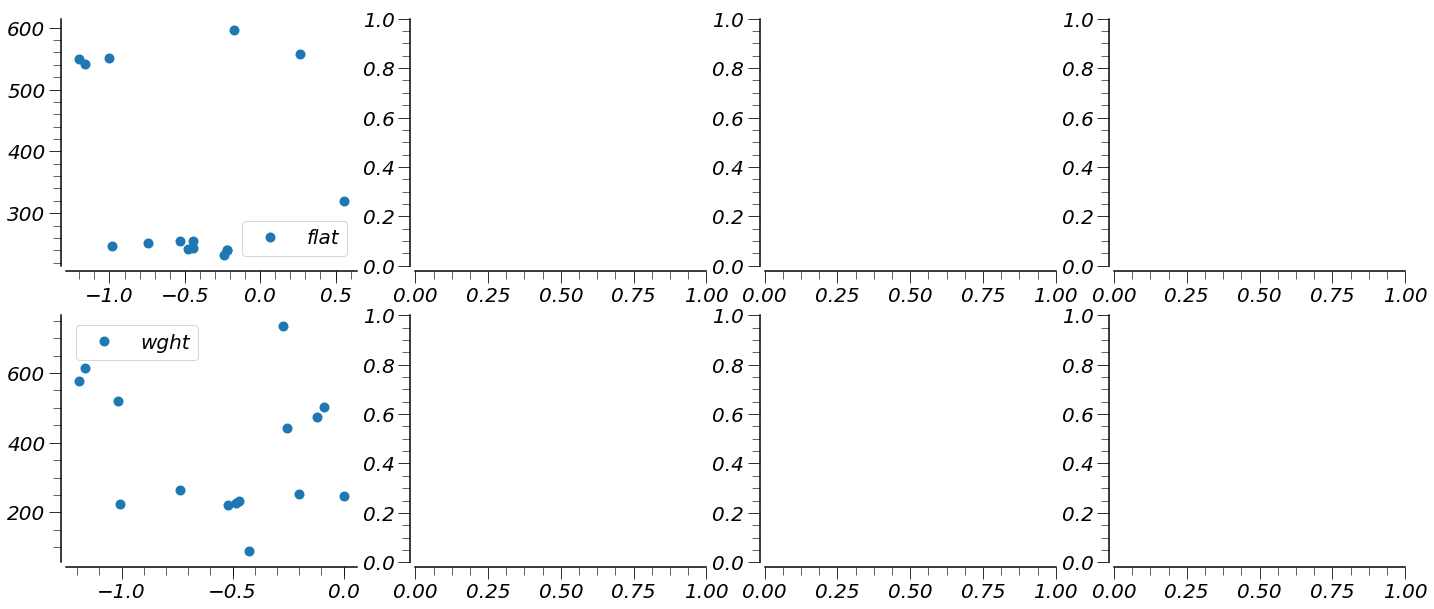

In [26]:
resps = [fit_flat, fit_wght];
case_str = ['flat', 'wght'];

rows = len(resps);
comps = 4; # how many comparisons?
f, ax = plt.subplots(nrows=rows, ncols=comps, figsize=(6*comps, 5*rows))

for i, r, s in zip(range(rows), resps, case_str):
    # plot normConst versus respScalar
    #   why? normConst also influences overall response amplitude
    normSig = [x[2] for x in r]
    scals = [x[4] for x in r]
    ax[i, 0].plot(normSig, scals, 'o', label=s)
    ax[i, 0].legend()
    
sns.despine(offset=5)